# Levanto los datos

In [1]:
import pandas as pd

df = pd.read_csv('/Users/przivic/Downloads/Registro para grupos de estudio 3.csv')

df = df.rename(
    columns={'Conocimientos de programación': 'coding_skills', 'Conocimientos de Machine Learning': 'ml_skills'}
)

len(df)

283

# Miramos distribución de las 2 preguntas

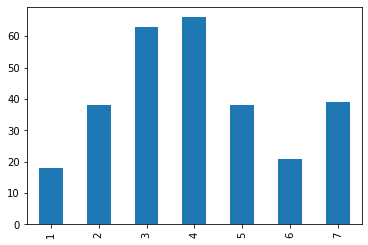

In [2]:
df.coding_skills.value_counts().sort_index().plot.bar()

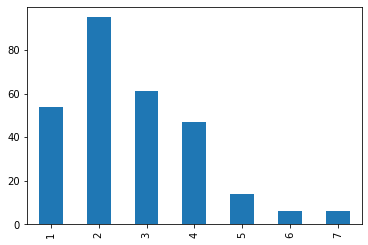

In [3]:
df.ml_skills.value_counts().sort_index().plot.bar()

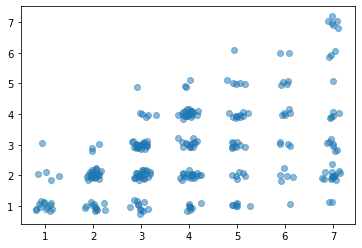

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(
    df.coding_skills + np.random.normal(0, 0.1, len(df)), 
    df.ml_skills + np.random.normal(0, 0.1, len(df)), 
    alpha=0.5
)

In [5]:
docs = df.to_dict(orient='records')

In [6]:
from functools import partial
import numpy as np

def pool_skills(group, func, key):
    return func([e[key] for e in group])

max_coding_skills = partial(pool_skills, func=max, key='coding_skills')
max_ml_skills = partial(pool_skills, func=max, key='ml_skills')
min_coding_skills = partial(pool_skills, func=min, key='coding_skills')
min_ml_skills = partial(pool_skills, func=min, key='ml_skills')

def bottle_neck(groups):
    # devuelve la suma de _bottle_neck
    return sum(map(_bottle_neck, groups))

def _bottle_neck(group):
    # devuelve un numero positivo si hay menos de 2 personas que saben mas de 3 en alguna dimensión
    return hinge(2 - len([e for e in group if max(e[k] for k in 'coding_skills ml_skills'.split()) >= 3]))

def n_experts(group, key, min_value=5):
    return len([e for e in group if e[key] >= min_value])
    
n_ml_experts = partial(n_experts, key='ml_skills')
n_coding_experts = partial(n_experts, key='coding_skills')

def n_rookies(group):
    return len([e for e in group if e['ml_skills'] == e['coding_skills'] == 1])

def hinge(n): return max(0, n)

def var(groups, key):
    # calcula la varianza respecto a una key
    return sum([np.std([e[key] for e in group]) for group in groups])

In [7]:
MIN_CODING_SKILLS = 4
MIN_ML_SKILLS = 4

def loss(groups):
    return (
        # Todos los grupos tienen que tener alguien que sepa de programacion
        sum([hinge(MIN_CODING_SKILLS - max_coding_skills(g)) for g in groups]) + 
        # Todos los grupos tienen que tener alguien que sepa de machine learning
        sum([hinge(MIN_ML_SKILLS - max_ml_skills(g)) for g in groups]) +

        # No hay grupos de todos expertos
        3 * sum([hinge(n_ml_experts(g) - 2) for g in groups]) + 
        3 * sum([hinge(n_coding_experts(g) - 2) for g in groups]) + 
        
        # Maximo 1 rookie por grupo
        3 * sum([hinge(n_rookies(g) - 1) for g in groups]) + 

        # Los grupos deben ser parejos en coding
        var(groups, 'coding_skills') + 
        # Los grupos deben ser parejos en machine learning
        var(groups, 'ml_skills') + 
        
        # Definitivamente no tiene que haber una persona que sea "la que sepa todo"
        bottle_neck(groups)
    )

In [8]:
from time import time
from random import shuffle, choice
from numba import jit

def random_groups(docs, group_size=4):
    # Crea una asignación al azar de grupos
    shuffle(docs)
    return [docs[start:start+group_size] for start in range(0, len(docs), group_size)]

def improve_locally(current_sol):
    # Toma el peor grupo segun la loss y trata de intercambiar con otros grupos 
    
    i, worst = max(enumerate(current_sol), key=lambda x: loss([x[1]]))
    worst_loss = loss([worst])
    for j, other in enumerate(current_sol):
        if i == j: continue
        other_loss = loss([other])
        
        for wg_i, w_person in enumerate(worst):
            for o_i, o_person in enumerate(other):
                new_worst = replace(worst, wg_i, o_person)
                new_other = replace(other, o_i, w_person)
                
                if loss([new_worst, new_other]) < worst_loss + other_loss:
                    candidate = (
                        [g for k, g in enumerate(current_sol) if k not in [i, j]] + 
                        [new_worst, new_other]
                    )
                    return candidate, loss(candidate)
                
    return current_sol, current_loss

def replace(group, index, person):
    res = group[:]
    res[index] = person
    return res

In [9]:
from tqdm.notebook import tqdm

def get_groups(docs, iters=150):
    groups = random_groups(docs)
    losses = []
    t0 = time()
    status = 'max_iter'
    for i in range(iters):
        groups, loss = improve_locally(groups)
        if losses and losses[-1] == loss: 
            status = 'local_minima'
            break
        losses.append(loss)
        
    return groups, losses, status

In [11]:
solutions = []
for i in tqdm(range(100)):
    solutions.append(get_groups(docs, iters=400))

In [13]:
from collections import Counter

# Vemos los statuses, a ver si las iteraciones estan bien
Counter([e[-1] for e in solutions])

Counter({'local_minima': 100})

In [14]:
import pickle as pkl

with open('solutions.pkl', 'wb') as f:
    pkl.dump(solutions, f, 2)

In [15]:
best, best_losses, best_status = min(solutions, key=lambda x: x[1][-1])

In [16]:
import pickle as pkl

to_save = [[{k: e[k] for k in 'Username coding_skills ml_skills'.split()}  for e in g] for g in best]
with open('groups.pkl', 'wb') as f:
    pkl.dump(to_save, f)

In [17]:
import encrypt

encrypt.encrypt_file('groups.pkl')

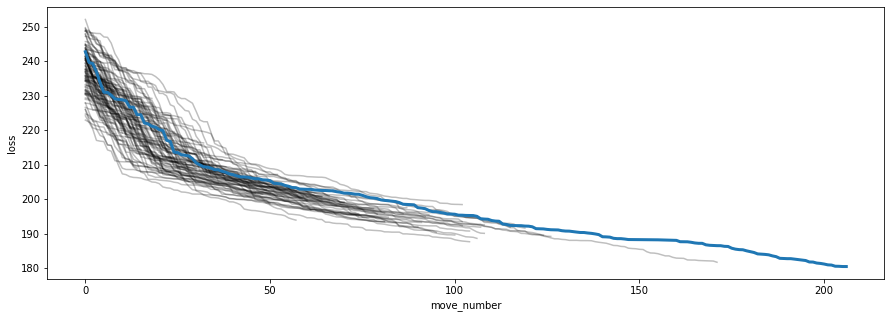

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for g, l, s in solutions:
    plt.plot(l, color='k', alpha=0.25)
    
plt.ylabel('loss')
plt.xlabel('move_number')
plt.plot(best_losses, lw=3)

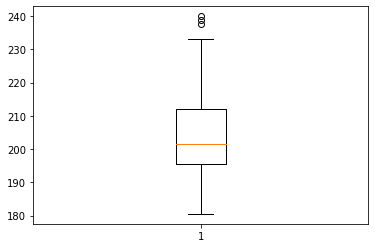

In [43]:
final_losses = [l[-1] for _, l, _ in solutions]
plt.boxplot(final_losses);

# Revisamos la mejor solucion y vemos que los grupos hayan quedado parejos

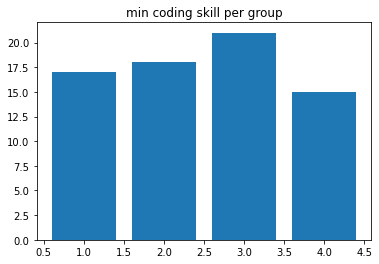

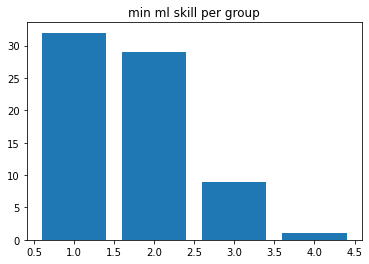

In [44]:
from collections import Counter

x, y = list(zip(*sorted(Counter(list(map(min_coding_skills, best))).items())))
plt.bar(x,y)
plt.title('min coding skill per group')

plt.figure()
x, y = list(zip(*sorted(Counter(list(map(min_ml_skills, best))).items())))
plt.bar(x,y)
plt.title('min ml skill per group');

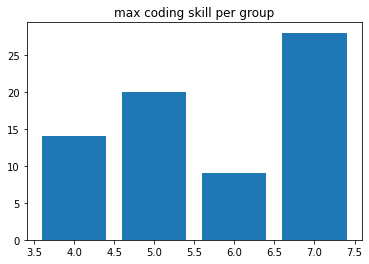

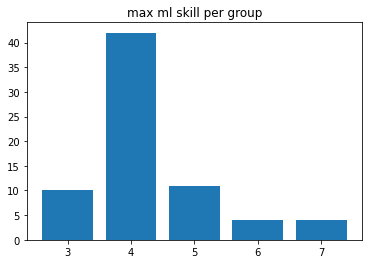

In [45]:
x, y = list(zip(*sorted(Counter(list(map(max_coding_skills, best))).items())))
plt.bar(x,y)
plt.title('max coding skill per group')

plt.figure()
x, y = list(zip(*sorted(Counter(list(map(max_ml_skills, best))).items())))
plt.bar(x,y)
plt.title('max ml skill per group');

In [46]:
from pprint import pprint

def tot_skills(g):
    return sum([e['coding_skills'] + e['ml_skills'] for e in g])

for g in sorted(best, key=tot_skills):
    pprint([{k: d[k] for k in 'ml_skills coding_skills'.split()} for d in g])
    print("*"*40)

[{'coding_skills': 2, 'ml_skills': 3},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 4, 'ml_skills': 1}]
****************************************
[{'coding_skills': 4, 'ml_skills': 3},
 {'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 1, 'ml_skills': 2},
 {'coding_skills': 3, 'ml_skills': 2}]
****************************************
[{'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 3, 'ml_skills': 1},
 {'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 5, 'ml_skills': 4}]
****************************************
[{'coding_skills': 4, 'ml_skills': 3},
 {'coding_skills': 1, 'ml_skills': 2},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 3, 'ml_skills': 2}]
****************************************
[{'coding_skills': 4, 'ml_skills': 4},
 {'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 3, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 2}]
****************************************
[{'coding_skill